# CPSC 330 Lecture 7

### Lecture plan

- Announcements
- EDA (15 min)
- Missing data (15 min)
- Break (5 min)
- Feature scaling (25 min)
- sklearn and ColumnTransformer (10 min)
- Trying a bunch of classifiers (10 min)

# TODO

look at old hyperopt lecture, get the hyperopt code that goes multiple levels deep with `__` because we now have many transformers 

# TODO

add learning outcomes / summary

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [3]:
plt.rcParams['font.size'] = 16

## Dealing with missing data (15 min)

In [118]:
df_train.sort_index().head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [119]:
df_train_nan = df_train.replace('?',np.NaN)
df_test_nan = df_test.replace('?',np.NaN)

df_train_nan.sort_index().head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,NaN,77053,HS-grad,9,Widowed,NaN,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,NaN,186061,Some-college,10,Widowed,NaN,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [122]:
X_train_nan = df_train_nan.drop(['income'], axis=1)
X_test_nan = df_test_nan.drop(['income'], axis=1)

- If we refer back to the profile report, we see that we only have missing values in the categorical features.

In [123]:
from sklearn.impute import SimpleImputer

In [124]:
imp = SimpleImputer(strategy='most_frequent')

- This imputer is another transformer, like the other ones we've seen.
- The "most_frequent" strategy puts in the most frequent value.
- There are also strategies for numeric variables, like taking the mean or median value.

In [125]:
imp.fit(X_train_nan[categorical_features]);

In [126]:
X_train_imp_cat = pd.DataFrame(imp.transform(X_train_nan[categorical_features]),
                           columns=categorical_features, index=X_train_nan.index)
X_test_imp_cat = pd.DataFrame(imp.transform(X_test_nan[categorical_features]),
                           columns=categorical_features, index=X_test_nan.index)

X_train_imp = X_train_nan.copy()
X_train_imp.update(X_train_imp_cat)

X_test_imp = X_test_nan.copy()
X_test_imp.update(X_test_imp_cat)

We can see the missing values filled in:

In [127]:
X_train_nan.sort_index().head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,90,NaN,77053,HS-grad,9,Widowed,NaN,Not-in-family,White,Female,0,4356,40,United-States
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States
2,66,NaN,186061,Some-college,10,Widowed,NaN,Unmarried,Black,Female,0,4356,40,United-States
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States


In [128]:
X_train_imp.sort_index().head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,90,Private,77053,HS-grad,9,Widowed,Prof-specialty,Not-in-family,White,Female,0,4356,40,United-States
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States
2,66,Private,186061,Some-college,10,Widowed,Prof-specialty,Unmarried,Black,Female,0,4356,40,United-States
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States


## Try different classifiers (10 min)

- Let's use cross-validation with our training set.
- This is implemented in `cross_val_score`

In [136]:
from sklearn.model_selection import cross_val_score

Example:

In [137]:
lr = LogisticRegression(max_iter=300)

In [138]:
scores = cross_val_score(lr, X_train_scale_ohe, y_train, cv=5)

In [139]:
scores

array([0.84760077, 0.85028791, 0.8452975 , 0.85813016, 0.85563448])

In [140]:
1.0 - np.mean(scores)

0.14860983629028313

There is also the slightly more sophisticated `cross_validate`, which gives us some extra information:

In [141]:
from sklearn.model_selection import cross_validate

In [142]:
lr = LogisticRegression(max_iter=300)

In [143]:
scores = cross_validate(lr, X_train_scale_ohe, y_train, cv=5, return_train_score=True)

In [144]:
scores

{'fit_time': array([1.58401108, 1.411165  , 0.99453616, 1.17865992, 0.94757175]),
 'score_time': array([0.01569891, 0.01687503, 0.017941  , 0.01524305, 0.01524019]),
 'test_score': array([0.84760077, 0.85028791, 0.8452975 , 0.85813016, 0.85563448]),
 'train_score': array([0.85449659, 0.85435263, 0.85526442, 0.85253611, 0.85157637])}

In [145]:
scores_df = pd.DataFrame(scores).drop(columns=['score_time'])
scores_df

,fit_time,test_score,train_score
0,1.584011,0.847601,0.854497
1,1.411165,0.850288,0.854353
2,0.994536,0.845298,0.855264
3,1.178660,0.858130,0.852536
4,0.947572,0.855634,0.851576


In [146]:
scores_df.mean()

fit_time       1.223189
test_score     0.851390
train_score    0.853645
dtype: float64

Now let's try some different classifiers:

In [ ]:
models = {'decision tree'      : DecisionTreeClassifier(),
          'logistic regression': LogisticRegression(max_iter=300),
          'RBF SVM'            : SVC(max_iter=1500), 
          'random forest'      : RandomForestClassifier(), 
         }
avg_scores = dict()

for model_name, model in models.items():
    print(model_name)
    scores = cross_validate(model, X_train_scale_ohe, y_train, cv=5, return_train_score=True)
    avg_scores[model_name] = pd.DataFrame(scores).drop(columns=['score_time']).mean()

In [147]:
pd.DataFrame(avg_scores).T

,fit_time,test_score,train_score
decision tree,0.415836,0.817568,0.999971
logistic regression,1.290177,0.851390,0.853645
RBF SVM,12.713557,0.637634,0.639338
random forest,3.931920,0.854922,0.999933


Let's discuss these results:

- Which methods are overfitting?
- Which methods are underfitting?
- Which methods are fast/slow?
- What is the best method so far?
- What hyperparameters should we tune?

In [148]:
models = {'decision tree'      : DecisionTreeClassifier(),
          'logistic regression orig': LogisticRegression(max_iter=300),
          'logistic regression': LogisticRegression(max_iter=300, C=100),
          'random forest orig'      : RandomForestClassifier(), 
          'random forest simpler'   : RandomForestClassifier(n_estimators=10)
         }
avg_scores = dict()

for model_name, model in models.items():
    print(model_name)
    scores = cross_validate(model, X_train_scale_ohe, y_train, cv=5, return_train_score=True)
    avg_scores[model_name] = pd.DataFrame(scores).drop(columns=['score_time']).mean()

decision tree
logistic regression orig
logistic regression
random forest orig
random forest simpler


In [149]:
pd.DataFrame(avg_scores).T

,fit_time,test_score,train_score
decision tree,0.475908,0.814919,0.999971
logistic regression orig,1.175866,0.851390,0.853645
logistic regression,1.364970,0.851313,0.853741
random forest orig,3.934673,0.854807,0.999914
random forest simpler,0.430480,0.847359,0.987245


## Break (5 min)

## Feature normalization/standardization (15 mins)

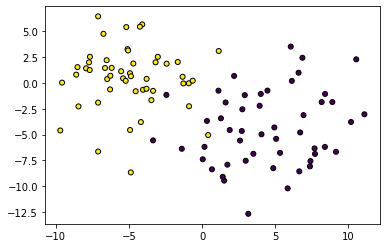

In [4]:
n_classes = 2
X, y = make_blobs(n_features=2, centers=2, cluster_std=3, random_state=123)

plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=25, edgecolor='k');

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.5,
                                                    random_state=123)

In [6]:
lr = LogisticRegression()
lr.fit(X_train, y_train);

/Users/mgelbart/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [7]:
show_scores(lr, X_train, y_train, X_test, y_test)

Training error: 0.060
Test     error: 0.020


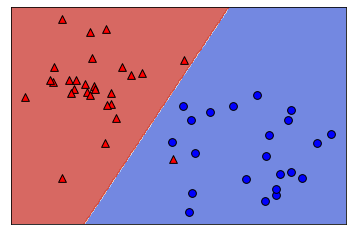

In [8]:
plot_classifier(X_test, y_test, lr);

- What happens if we scale the first feature by 1/1000?
- You could imagine these being distances, and now we've collected one of them in kilometres instead of metres.
  - Intuitively, this should not affect the predictive power of our model.

In [9]:
X_train2 = X_train.copy()
X_train2[:,0] /= 1000
X_test2 = X_test.copy()
X_test2[:,0] /= 1000

In [10]:
X_train2[:10]

array([[ 1.67741709e-04, -6.19046781e+00],
       [-7.73228256e-03,  1.99135511e+00],
       [ 6.75679976e-04, -8.36762793e+00],
       [-7.10973217e-03, -1.90787774e+00],
       [ 1.05471740e-02,  2.28314497e+00],
       [-1.33119848e-03,  5.96767459e-01],
       [ 4.87219970e-03, -8.25600968e+00],
       [-4.87191413e-03, -8.66686964e+00],
       [ 3.93792146e-03, -2.21254517e+00],
       [-4.54081827e-03, -8.07380639e-01]])

In [11]:
lr2 = LogisticRegression()
lr2.fit(X_train2, y_train);

/Users/mgelbart/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [12]:
show_scores(lr2, X_train2, y_train, X_test2, y_test)

Training error: 0.260
Test     error: 0.180


- Note that the test error went up from 2% to 18%!!
- Decision trees don't have this problem:

In [13]:
dt = DecisionTreeClassifier(random_state=1)
dt.fit(X_train, y_train)
show_scores(dt, X_train, y_train, X_test, y_test)

Training error: 0.000
Test     error: 0.040


In [14]:
dt = DecisionTreeClassifier(random_state=1)
dt.fit(X_train2, y_train)
show_scores(dt, X_train2, y_train, X_test2, y_test)

Training error: 0.000
Test     error: 0.040


- Hmm, this does worse. What is happening?
- Answer: `LogisticRegression` is sensitive to the scaling of the features (especially for small `C`).
  - There is an implicit assumption that the different features are on a "level playing field".
  - Which means if one of them has really small values, it's not being considered much.

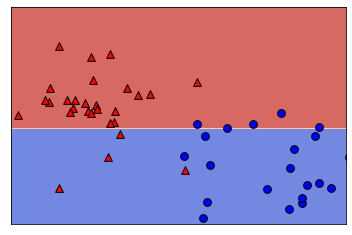

In [15]:
plot_classifier(X_test2, y_test, lr2, lims=(-.01, .01, -10, 10));

- It seems the model is just predicting a horizontal line!
- It is worrying that we get such a bad result.

- This problem affects a large number of ML methods.
- Two approaches to this problem are standardization and normalization


| Approach | What it does | How to update $X$ (but see below!) | sklearn implementation | 
|---------|------------|-----------------------|----------------|
| normalization | sets range to $[0,1]$   | `X -= np.min(X,axis=0)`<br>`X /= np.max(X,axis=0)`  | [`MinMaxScaler()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)
| standardization | sets sample mean to $0$, s.d. to $1$   | `X -= np.mean(X,axis=0)`<br>`X /=  np.std(X,axis=0)` | [`StandardScaler()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) |

There are all sorts of articles on this; see, e.g. [here](http://www.dataminingblog.com/standardization-vs-normalization/) and [here](https://medium.com/@rrfd/standardize-or-normalize-examples-in-python-e3f174b65dfc).

- Let's see a quick example of using these scaling methods

In [16]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [17]:
scaler = StandardScaler()
scaler.fit(X_train2)
X_train2_scaled = scaler.transform(X_train2)
X_test2_scaled = scaler.transform(X_test2)

- Note the same Golden Rule issue we talked about last class!!
- We fit the transformer on the training data, and then transform both data sets.

Let's check that it did what we expected:

In [18]:
X_train2_scaled.mean(axis=0)

array([3.10862447e-17, 7.77156117e-17])

In [122]:
X_train2_scaled.std(axis=0)

array([1., 1.])

Note that for test we get something different - that is OK!!

In [123]:
X_test2_scaled.mean(axis=0)

array([0.00499913, 0.24599373])

In [124]:
X_test2_scaled.std(axis=0)

array([1.15537989, 0.92337763])

In [125]:
lr3 = LogisticRegression()
lr3.fit(X_train2_scaled, y_train);

In [126]:
show_scores(lr3, X_train2_scaled, y_train, X_test2_scaled, y_test)

Training error: 0.080
Test     error: 0.020


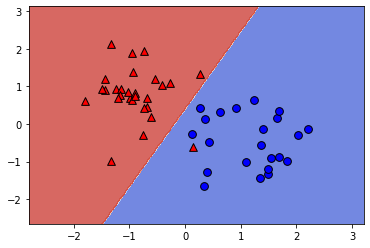

In [127]:
plot_classifier(X_test2_scaled, y_test, lr3, ticks=True);

Here we got back something reasonable.

In [131]:
minmax = MinMaxScaler()
minmax.fit(X_train2)
X_train2_minmax = minmax.transform(X_train2)
X_test2_minmax  = minmax.transform(X_test2)

Let's again check the results:

In [132]:
X_train2_minmax.min(axis=0)

array([0., 0.])

In [133]:
X_train2_minmax.max(axis=0)

array([1., 1.])

And again for test:

In [137]:
X_test2_minmax.min(axis=0)

array([0.0060665 , 0.17735288])

In [138]:
X_test2_minmax.max(axis=0)

array([1.02762574, 1.05531983])

In [139]:
lr4 = LogisticRegression()
lr4.fit(X_train2_minmax, y_train);

In [140]:
show_scores(lr4, X_train2_minmax, y_train, X_test2_minmax, y_test)

Training error: 0.080
Test     error: 0.040


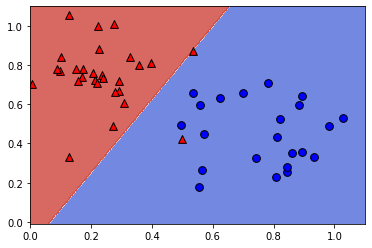

In [141]:
plot_classifier(X_test2_minmax, y_test, lr4, ticks=True, lims=(0, 1.1, -0.01, 1.1));

And, again, something reasonable.

In general, I would guess standardization is more popular, but you see normalization too.

#### Preprocessing the targets?

- Generally not needed, but we sometimes do.
- More on this below, with one-hot encoding.

![](img/column-transformer.png)

Adapted from [here](https://amueller.github.io/COMS4995-s20/slides/aml-04-preprocessing/#37).

- Can we do better? What about our discussion of scaling from earlier?
- Our features are not on the same scale and our encodings are getting "drowned out" by `age` and `weight`.
- We should preprocess both numeric features (e.g., scaling) and categorical features (e.g., OHE).
- sklearn's [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) makes this more manageable.
  - A big advantage here is that we build all our transformations together into one object, and that way we're sure we do the same operations to all splits of the data. 
  - Otherwise we might, for example, do the OHE on both train and test but forget to scale the test data.

In [119]:
from sklearn.compose import ColumnTransformer

In [120]:
# Identify the categorical and numeric columns
numeric_features = ['age', 'weight']
categorical_features = ['treatment']

In [122]:
transformers=[
    ('scale', StandardScaler(), numeric_features),
    ('ohe', OneHotEncoder(drop='first'), categorical_features)]

In [123]:
# Create the transformer
preprocessor = ColumnTransformer(transformers=transformers)

When we fit the preprocessor, it fits _all_ the transformers.

In [125]:
preprocessor.fit(X);

We can get the new names of the columns that were generated by the one-hot encoding:

In [126]:
preprocessor.named_transformers_['ohe'].get_feature_names(categorical_features)

array(['treatment_B', 'treatment_C'], dtype=object)

Combining this with the numeric feature names gives us all the column names:

In [127]:
columns = numeric_features + list(preprocessor.named_transformers_['ohe']
                                     .get_feature_names(categorical_features))
columns

['age', 'weight', 'treatment_B', 'treatment_C']

Like fit, when we transform with the preprocessor, it calls `transform` on _all_ the transformers.

In [129]:
# Apply data transformations and convert back to dataframe
X_ohe_scale = pd.DataFrame(preprocessor.transform(X),
                       index=X.index,
                       columns=columns)

In [130]:
X_ohe_scale.head()

,age,weight,treatment_B,treatment_C
0,-1.602301,-1.294360,0.0,0.0
1,-1.463640,-1.204307,1.0,0.0
2,-0.978328,-1.197103,1.0,0.0
3,-1.740961,-1.982364,0.0,1.0
4,-1.116989,0.099659,0.0,0.0


- Side note: the `ColumnTransformer` will automatically remove columns that are not being transformed:

In [132]:
preprocessor = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(drop='first'), categorical_features)])

preprocessor.fit_transform(X)

array([[0., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 0.],
       [0., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 0.],
       [0., 0.],
       [1., 0.],
       [0., 1.],
       [0., 0.],
       [1., 0.],
       [0., 0.],
       [1., 0.],
       [1., 0.],
       [0., 0.],
       [0., 1.],
       [0., 1.],
       [0., 0.],
       [0., 1.]])

Using `remainder='passthrough'` keeps the other columns in tact:

In [133]:
preprocessor = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(drop='first'), categorical_features)], 
                                 remainder='passthrough')

preprocessor.fit_transform(X)

array([[  0. ,   0. ,  21. ,  57.8],
       [  1. ,   0. ,  23. ,  60.3],
       [  1. ,   0. ,  30. ,  60.5],
       [  0. ,   1. ,  19. ,  38.7],
       [  0. ,   0. ,  28. ,  96.5],
       [  0. ,   1. ,  23. ,  41.8],
       [  1. ,   0. ,  33. , 111. ],
       [  0. ,   1. ,  67. , 158. ],
       [  1. ,   0. ,  42. , 109.4],
       [  0. ,   0. ,  33. ,  66.5],
       [  0. ,   0. ,  33. , 111.4],
       [  0. ,   1. ,  56. , 114.7],
       [  0. ,   1. ,  45. ,  91.6],
       [  1. ,   0. ,  43. ,  89.8],
       [  0. ,   0. ,  38. , 102.4],
       [  0. ,   1. ,  37. ,  75.7],
       [  1. ,   0. ,  43. ,  87.4],
       [  0. ,   1. ,  27. ,  49.9],
       [  0. ,   0. ,  43. ,  94.2],
       [  1. ,   0. ,  45. , 132. ],
       [  1. ,   0. ,  48. , 113.5],
       [  0. ,   1. ,  47. , 136. ],
       [  0. ,   0. ,  48. ,  95.3],
       [  0. ,   0. ,  53. , 121.6],
       [  1. ,   0. ,  58. , 121.1],
       [  0. ,   1. ,  29. ,  89.2],
       [  0. ,   0. ,  53. , 107.3],
 

Hyperopt code from lecture 5:

In [209]:
param_grid = {
              "n_estimators"     : [10,100],
              "max_depth"        : [3, None],
              "max_features"     : [3, None]
             }
param_grid

{'n_estimators': [10, 100], 'max_depth': [3, None], 'max_features': [3, None]}

- How many combinations in total? 
- $2\times 2\times 2=8$

In [210]:
np.prod(list(map(len, param_grid.values())))

8

In [211]:
rf = RandomForestClassifier(random_state=321)
grid_search = GridSearchCV(rf, param_grid, cv=3, verbose=1)

In [212]:
grid_search.fit(X_train_transformed, y_train);

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  1.3min finished


In [213]:
grid_search.best_params_

{'max_depth': None, 'max_features': None, 'n_estimators': 100}

- lol... these are the default values.
- I guess they picked good defaults!

In [214]:
grid_search.best_score_

0.8549216369281329

In [215]:
pd.DataFrame(grid_search.cv_results_)[['mean_test_score', 'param_max_depth', 'param_max_features', 'param_n_estimators', 'mean_fit_time', 'rank_test_score']].set_index("rank_test_score").sort_index()

,mean_test_score,param_max_depth,param_max_features,param_n_estimators,mean_fit_time
rank_test_score,,,,,
1,0.854922,None,None,100,14.519656
2,0.848587,None,None,10,1.399292
3,0.848127,None,3,100,1.986127
4,0.844748,3,None,10,0.517570
4,0.844748,3,None,100,5.280527
6,0.839527,None,3,10,0.226066
7,0.761057,3,3,10,0.189320
8,0.760519,3,3,100,0.907236


- Note that the grid search object acts like a scikit-learn model.
- It was actually refit on the _whole_ training set, as discussed earlier in the course!
- I believe it is the same as `grid_search.best_estimator_`.

In [216]:
grid_search.predict(X_test_transformed)

array(['<=50K', '>50K', '<=50K', ..., '>50K', '<=50K', '<=50K'],
      dtype=object)